In [5]:
import numpy as np
import pandas as pd
import cv2

%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import gridspec

import time
from datetime import datetime

from tqdm.notebook import tqdm

# Introduction à OpenCV2

#### Plan

 1. Importation d'une image
 1. Visualisation des channels en RGB et HSV
 1. Évolution des 3 couleurs le long d'une ligne
 1. Recadrage et concaténation
 1. Blending (ajout d'une image sur une autre)
 1. Enregistrement d'une image
 1. Exercice 1
 1. Exercice 2

## Importation d'une image

Pour que matplotlib affiche correctement les couleurs, il faut passer en RGB depuis BGR.


Comme le notebook s'exécute sur un serveur distant, il n'est pas possible d'appeller la fonction cv2.imshow(). On passe donc via matplotlib avec plt.imshow().

<IPython.core.display.Javascript object>


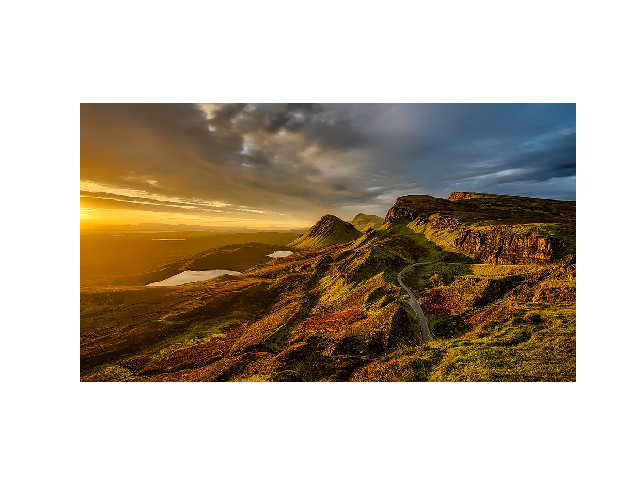

In [6]:
image = cv2.imread("../data/images/paysage.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure()
plt.axis('off')
plt.imshow(image)
plt.show()

In [4]:
print(f"Taille de l'image :{image.shape}")

Taille de l'image :(540, 960, 3)


## Visualisation des channels en RGB et HSV

Dans un premier temps, les channels RGB sont extraits avec du "slicing" sur le 3ème axe.


Une fois l'image passée en HSV avec cv2.cvtColor(), on affiche les 3 channels.

<IPython.core.display.Javascript object>


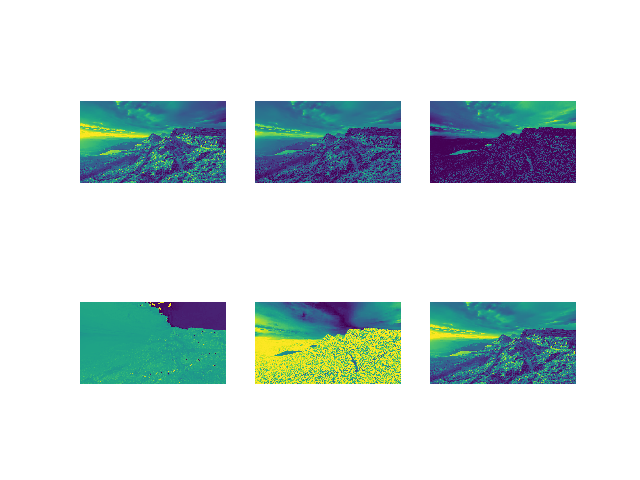

In [7]:
blue_ch = image[:, :, 0]
green_ch = image[:, :, 1]
red_ch = image[:, :, 2]

image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
hue_ch = image_hsv[:, :, 0]
saturation_ch = image_hsv[:, :, 1]
value_ch = image_hsv[:, :, 2]

images = [
    blue_ch, green_ch, red_ch,
    hue_ch, saturation_ch, value_ch
]

plt.figure()
for i, img in enumerate(images):
    plt.subplot(2, 3, i+1)
    plt.axis('off')
    plt.imshow(img)
plt.show()

## Évolution des 3 couleurs le long d'une ligne

Avec le code ci dessous, on voit l'évolution de l'intensité des 3 channels le long d'une droite. 2 lignes coupent l'image et le plan des couleurs. Elles montrent la valeur RGB en ce pixel.

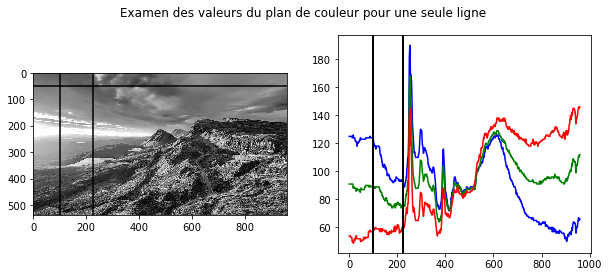

In [5]:
fig = plt.figure(figsize=(10, 4))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

# original image
ax0 = plt.subplot(gs[0])
ax0.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) # need to convert BGR to RGB
ax0.axhline(50, color='black') # show the row being used
ax0.axvline(100, color='k'), ax0.axvline(225, color='k') # ref lines# image slice

ax1 = plt.subplot(gs[1])
ax1.plot(blue_ch[49, :], color='blue')
ax1.plot(green_ch[49, :], color='green')
ax1.plot(red_ch[49, :], color='red')
ax1.axvline(100, color='k', linewidth=2), ax1.axvline(225, color='k', linewidth=2)

plt.suptitle('Examen des valeurs du plan de couleur pour une seule ligne')
plt.show()

## Recadrage et concatenation

Une image sous OpenCV est vu comme une matrice de Numpy. Du "slicing" peut être appliqué à l'image pour la recadrer.


En soit, toutes les opérations de Numpy peuvent être faites tant que cela conservent une dimension de (width, height, channels) ainsi que des plages de valeurs de 0 à 1 ou de 0 à 255.

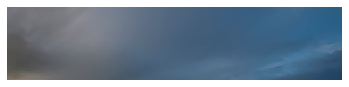

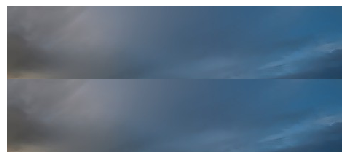

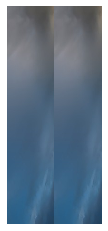

In [6]:
croped_img = image[:100, 500:, :]
plt.figure()
plt.axis('off')
plt.imshow(croped_img)
plt.show()

stack_img = np.concatenate([croped_img, croped_img], axis=0)
plt.figure()
plt.axis('off')
plt.imshow(stack_img)
plt.show()

plt.figure()
plt.axis('off')
plt.imshow(np.swapaxes(stack_img,0,1))
plt.show()

## Blending

Toujours en prenant en compte qu'une image est juste une matrice, il est possible d'ajouter une image par dessus une autre.

#### Cas simple
Dans le premier cas, nous sommes dans un cas simple. Une addition suffit pour rajouter le "text" en blanc sur une image quelconque. Car 255 + anything = 255
Il faut cependant utiliser la méthode d'OpenCV (et non juste une addition) pour écréter les valeurs supérieures à 255.

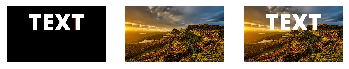

In [7]:
text = cv2.imread("../data/images/white_text.png")

# Add black pixels around text for blending
padding_l = int((image.shape[1] - text.shape[1])/2)
padding_r = image.shape[1] - text.shape[1] - padding_l

pad_l = np.zeros((text.shape[0], int(padding_l), 3), dtype=np.uint8)
pad_r = np.zeros((text.shape[0], int(padding_r), 3), dtype=np.uint8)
text = np.concatenate([pad_l, text, pad_r], axis=1)

padding = image.shape[0]-text.shape[0]
pad = np.zeros((padding, image.shape[1], 3), dtype=np.uint8)
text = np.concatenate([text, pad], axis=0)

# Then add
new = cv2.add(image, text)

plt.figure()
for i, img in enumerate([text, image, new]):
    plt.subplot(1, 3, i+1)
    plt.axis('off')
    plt.imshow(img)
plt.show()

#### Cas plus complexe
Dans le second cas, c'est une image qui n'est pas complètement blanche. Quand on l'ajoute, le résultat sera un mélange des 2 pixels.
Pour cela, un masque est applliqué à l'image pour obtenir une surface noire à l'emplacement de l'image ajoutée. Puis x + 0 = x

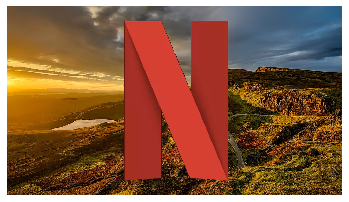

In [8]:
logo = cv2.imread("../data/images/netflix.jpg")
logo =  cv2.cvtColor(logo, cv2.COLOR_RGB2BGR)

# Resize to have the same shape between text and 
logo = cv2.resize(logo, image.shape[:2][::-1])

bin_logo = cv2.cvtColor(logo, cv2.COLOR_BGR2GRAY)
bin_logo = ((bin_logo < 7)*1).astype(np.uint8)
bin_logo = bin_logo[:, :, None]

# Apply the mask
res = cv2.bitwise_and(image, image, mask=bin_logo)
# Then add the logo
res += logo

plt.figure()
plt.axis('off')
plt.imshow(res)
plt.show()

## Enregistrement d'une image

In [9]:
cv2.imwrite("../data/output/antoine.jpg", image)

True

## Exercice 1
### Ou comment voir l'effet de la brise

Pour la détection de mouvement, l'algorithme se base sur une image de référence. Puis pour chaque frame de la vidéo, ces étapes sont appliquées :
 1. Lissage (blur gaussian)
 1. Différence entre l'image de référence
 1. Application d'un seuil
 1. Détéction de contour
 
Établir un seuil est une étape important afin d'atténuer les variations légères. Elles ont souvent comme origines des altérations de l'environnement, par exemple une modification de la lumière (il peut être bon de renouveler de temps en temps cette image de référence.). Mais le seuil permet aussi de binariser l'image pour un traitement plus simple.

Toujours dans l'optique d'éviter les parasites, le programme ajoute un second seuil. Ce coup-ci, il limite les mouvements de petite empleur détéctés.

Exo 1

In [12]:
# Assigning our static_back to None 
static_back = None

# Open video 
video = cv2.VideoCapture("../data/videos/security_vid.webm")
output = cv2.VideoWriter("../data/output/A_detection.mp4",cv2.VideoWriter_fourcc(*'MP4V'), 30, (1280,960))

length = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
state = tqdm(total=length, desc="Frames")

# Infinite while loop to treat stack of image as video 
while video.isOpened():
    # Reading frame(image) from video 
    ret, frame = video.read() 
    if ret == False:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) 

    # Converting gray scale image to GaussianBlur
    gray = cv2.GaussianBlur(gray, (21, 21), 0) 

    # In first iteration we assign the value 
    # of static_back to our first frame 
    if static_back is None: 
        static_back = gray 
        continue

    # Difference between static background 
    # and current frame(which is GaussianBlur) 
    diff_frame = cv2.absdiff(static_back, gray) 

    # If change in between static background and 
    # current frame is greater than 30 it will show white color(255) 
    thresh_frame = cv2.threshold(diff_frame, 30, 255, cv2.THRESH_BINARY)[1] 
    thresh_frame = cv2.dilate(thresh_frame, None, iterations = 2) 

    # Finding contour of moving object 
    cnts, _ = cv2.findContours(thresh_frame.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) 

    for contour in cnts: 
        if cv2.contourArea(contour) < 4000: 
            continue
        motion = 1

        (x, y, w, h) = cv2.boundingRect(contour) 
        # Making green rectangle arround the moving object 
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 3) 

    # Display the result and all intermediate steps
    gray = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB) 
    diff_frame = cv2.cvtColor(diff_frame, cv2.COLOR_GRAY2RGB) 
    thresh_frame = cv2.cvtColor(thresh_frame, cv2.COLOR_GRAY2RGB) 
    
    top = np.concatenate((gray, diff_frame), axis=1)
    bottom = np.concatenate((thresh_frame, frame), axis=1)
    res = np.concatenate((top, bottom))
    
    output.write(res)   
    state.update()
    
state.close()
video.release()
output.release()

## Exercice 2
### Ou comment manipuler des Numpy arrays

Le code se suffit à lui-même.

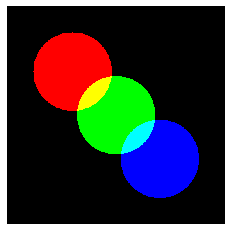

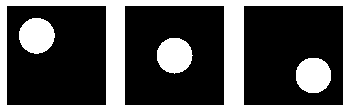

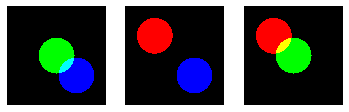

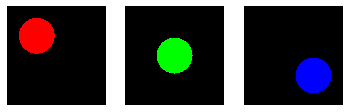

In [13]:
c_b = np.zeros((500, 500, 3))
cv2.circle(c_b, (150, 150), 90, (255, 0, 0), -1)
c_g = np.zeros((500, 500, 3))
cv2.circle(c_g, (250, 250), 90, (0, 255, 0), -1)
c_r = np.zeros((500, 500, 3))
cv2.circle(c_r, (350, 350), 90, (0, 0, 255), -1)

frame = c_b + c_g + c_r

plt.figure()
plt.axis("off")
plt.imshow(frame.astype('uint8'))
plt.show()

plt.figure()
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.axis("off")
    tmp = frame[:, :, i]
    plt.imshow(tmp.astype(np.uint8), cmap="gray")
plt.show()

plt.figure()
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.axis("off")
    tmp = frame.copy()
    tmp[:, :, i] = 0
    plt.imshow(tmp.astype(np.uint8))
plt.show()

plt.figure()
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.axis("off")
    tmp = np.zeros_like(frame)
    tmp[:, :, i] = frame[:, :, i]
    plt.imshow(tmp.astype(np.uint8))
plt.show()